 # Assignment 3 - RNNS
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

In this notebook I will go over chapter 8 of D2L, which is about RNNs.

# Sequence Models (8.1)

In this section, I will create a few sequence models. The dataset that will be used for this model is a sine wave with some added noise.

Text(0, 0.5, 'x')

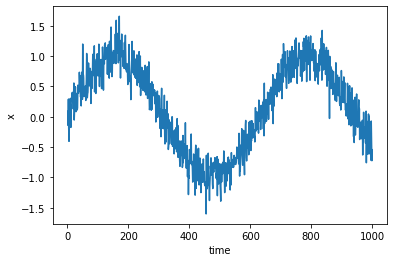

In [2]:
T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0,0.2, (T,)) # Sine wave with some noise
plt.plot(time, x)
plt.xlabel('time')
plt.ylabel('x')

The first sequence model will be based on features of length $\tau$ before a point to be predicted, more specifically $y_t=x_t$ and $x_t=[x_{t-\tau}, ..., x_{t-1}]$.

The code below creates these features and labels with $\tau$ of 4 and a total of 600 training examples from the above dataset.

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
  features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600

class TimeSeriesDataset(Dataset):
  def __init__(self, features, labels):
        self.labels = labels
        self.features = features
  def __len__(self):
          return len(self.labels)
  def __getitem__(self, idx):
          label = self.labels[idx, :]
          feature = self.features[idx]
          sample = (feature, label)
          return sample

dataset = TimeSeriesDataset(features[:n_train], labels[:n_train])

train_iter = DataLoader(dataset, batch_size=16)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

The architecture that will be used in this model is a simple MLP with two fully connected layers, a ReLU activation function, and a mean squared loss function.

In [5]:
net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(),
                    nn.Linear(10, 1))
net.apply(init_weights)

Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

Below is the code that will be used to train the model.

In [6]:
def train(net, train_iter, criterion, epochs, lr):
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(1, epochs + 1):
        running_loss = 0.0
        for X, y in train_iter:
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.sum().backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'epoch {epoch}, ', f'loss: {running_loss /len(train_iter)}')

Now the model will be trained with a learning rate of 0.001 and a total of 5 epochs.

In [7]:
criterion = nn.MSELoss()
train(net, train_iter, criterion, 5, 0.001)

epoch 1,  loss: 0.33485038362835584
epoch 2,  loss: 0.16772330748407463
epoch 3,  loss: 0.11420278704578155
epoch 4,  loss: 0.09696303146254075
epoch 5,  loss: 0.09114520420859519


In [8]:
preds = net(features)

From the visualization below, we can see that the model is able to predict the dataset well.

[]

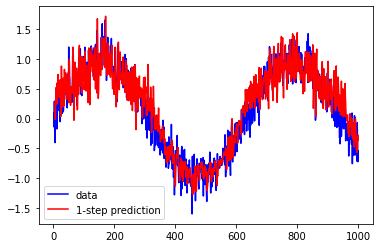

In [9]:
plt.plot(time, x, c='blue', label='data')
plt.plot(time[tau:], preds.detach().numpy(), c='red', label='1-step prediction')
plt.legend()
plt.plot()

Now, if we would like to make predictions far into the future, we can implement multistep prediction. This method, uses the network's predictions to predict subsequent predictions. Below is an implementation of multistep prediction for $n_{train} + \tau$ to $T$.

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

[]

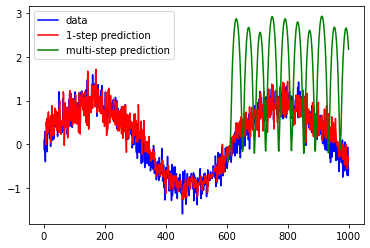

In [11]:
plt.plot(time, x, c='blue', label='data')
plt.plot(time[tau:], preds.detach().numpy(), c='red', label='1-step prediction')
plt.plot(time[n_train + tau:], multistep_preds[n_train + tau:].detach().numpy(), c='green', label='multi-step prediction')
plt.legend()
plt.plot()

We can see that the results of multistep prediction degrades after several steps.

Now, let's visualize the model for steps $k=1, 4, 16,$ and $64$.

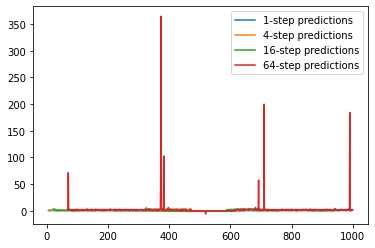

In [12]:
max_steps = 64

features = torch.zeros(T - tau - max_steps + 1, tau + max_steps)

# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

for i in [1, 4, 16, 64]:
    plt.plot(time[tau + i - 1: T - max_steps + i], features[:, (tau + i - 1)].detach().numpy(), label=f'{i}-step predictions')
    plt.legend()
    plt.plot()

# Text Preprocessing (8.2)

In this section, I will go over the text preprocessing steps used preprocess text data before processing it as sequenced data. These steps include:: (1) loading text as strings into memory; (2) splitting strings into tokens (e.g. words and characters); (3) building a table of vocabulary to map the split tokens to numerical indicies; and (4) converting text into sequences of numerical indicies so they can be manipulated.

I will use d2l's download function to retreive H. G. Wells' "The Time Machine".

In [13]:
!pip install d2l

     |████████████████████████████████| 82 kB 534 kB/s 
     |████████████████████████████████| 15.7 MB 335 kB/s 
     |████████████████████████████████| 11.2 MB 29.1 MB/s 
     |████████████████████████████████| 9.9 MB 20.8 MB/s 
     |████████████████████████████████| 61 kB 5.4 MB/s 
     |████████████████████████████████| 930 kB 33.0 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependen

In [14]:
import collections 
import re
from d2l import torch as d2l

In [15]:
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine(): 
    """Load the time machine dataset into a list of text lines."""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


The following function tokenizes lines of input by splitting the input into a list of tokens (words or characters). 

In [16]:
def tokenize(lines, token='word'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']



After tokenizing the lines, a dictionary (also known as vocabulary) is created to map string tokens into numerical indicies. 

The next step after tokenizing is to build a vocabulary. The vocabulary is used to count the unique tokens in all the documents in a training set, called a corpus, and assign a numerical index to each unique token according to its frequency. To reduce complexity, rarely appearing tokens are removed. If a token does not exist in a corpus, then it is mapped to a special token "`<unk>`". Optionally, we can also add a list of reserved tokens, such as "`<pad>`" for padding, "`<bos>`" to indicate the beginningg of a sequence, and "`<eos>`" to indicate the end of sequence.

In [17]:
class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    @property
    def unk(self):
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):
    # 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

With the class above, I will create a vocabulary based on the tokens I generated

In [18]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


Additionally, we can preview a several lines in the document and see the indicies of the contained tokens.

In [19]:
for i in range(11):
    print('words:', tokens[i])
    print('indicies:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indicies: [1, 19, 50, 40, 2183, 2184, 400]
words: []
indicies: []
words: []
indicies: []
words: []
indicies: []
words: []
indicies: []
words: ['i']
indicies: [2]
words: []
indicies: []
words: []
indicies: []
words: ['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
indicies: [1, 19, 71, 16, 37, 11, 115, 42, 680, 6, 586, 4, 108]
words: ['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
indicies: [7, 1420, 5, 2185, 587, 6, 126, 25, 330, 127, 439, 3]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indicies: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


With the functions above, I will now combine them into a single function. Unlike the steps above, I will tokenize based on characters to help future training.

In [20]:
def load_corpus_time_machine(max_tokens=-1):
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)

    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
corpus, vocab = load_corpus_time_machine()
len(corpus) , len(vocab)

(170580, 28)

# Learning a Language Model (8.3)

## 9.3.3 Natural Language Statistics

In [21]:
import random

In [22]:
corpus = [token for line in tokens for token in line]
vocab = Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

Text(0, 0.5, 'Frequency: n(x)')

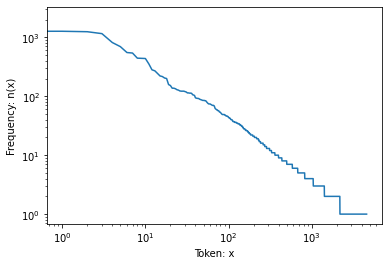

In [23]:
fig, ax = plt.subplots()
freqs = [freq for token, freq in vocab.token_freqs]
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(freqs)
ax.set_xlabel('Token: x')
ax.set_ylabel('Frequency: n(x)')

As you can see the word frequency of unigrams decay rapidly

In [24]:
bigram_tokens =[pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [25]:
trigram_tokens =[triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

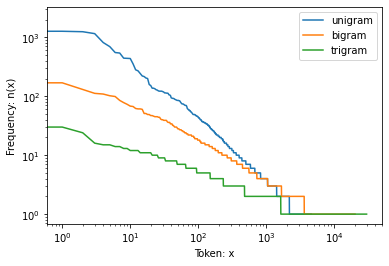

In [26]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

fig, ax = plt.subplots()
freqs = [freq for token, freq in vocab.token_freqs]
ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(freqs, label='unigram')
ax.plot(bigram_freqs, label='bigram')
ax.plot(trigram_freqs, label='trigram')
ax.set_xlabel('Token: x')
ax.set_ylabel('Frequency: n(x)')
ax.legend()

Here are the frequencies for unigrams, bigrams, and trigrams. As you can see, bigrams and trigrams occur alot less than unigrams. This indicates that there might be structure in language.

### 8.3.4.1 Random Sampling

In [27]:
def seq_data_iter_random(corpus, batch_size, num_steps): 
    """Generate a minibatch of subsequences using random sampling."""
    # Start with a random offset (inclusive of `num_steps - 1`) to partition a
    # sequence
    corpus = corpus[random.randint(0, num_steps - 1):]
    # Subtract 1 since we need to account for labels
    num_subseqs = (len(corpus) - 1) // num_steps
    # The starting indices for subsequences of length `num_steps`
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # In random sampling, the subsequences from two adjacent random
    # minibatches during iteration are not necessarily adjacent on the
    # original sequence
    random.shuffle(initial_indices)

    def data(pos):
        # Return a sequence of length `num_steps` starting from `pos`
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # Here, `initial_indices` contains randomized starting indices for
        # subsequences
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [28]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [15, 16, 17, 18, 19]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [16, 17, 18, 19, 20]])
X:  tensor([[20, 21, 22, 23, 24],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [ 6,  7,  8,  9, 10]])
X:  tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [26, 27, 28, 29, 30]])


### 8.3.4.2 Sequential Partitioning

In [29]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): 
    """Generate a minibatch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [30]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)


X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


Combine both sampling functions into one function

In [31]:
class SeqDataLoader: 
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [32]:
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 8.5 Implementation of Recurrent Neural Networks from scratch

In [33]:
from torch.nn import functional as F

In [34]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

In [35]:
X = torch.arange(10).reshape((2, 5))


In [36]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [37]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [38]:
def rnn(inputs, state, params):
    # Here `inputs` shape: (`num_steps`, `batch_size`, `vocab_size`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # Shape of `X`: (`batch_size`, `vocab_size`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [39]:
class RNNModelScratch: 
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [40]:
device = torch.device('cuda')

In [41]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], device)
Y, new_state = net(X.to(device), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [42]:
def predict_ch8(prefix, num_preds, net, vocab, device): 
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [43]:
predict_ch8('time traveller ', 10, net, vocab, device)

'time traveller qvsfrzbtvs'

Gradient Clipping

In [44]:
def grad_clipping(net, theta): 
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 8.5.6 Training

In [45]:
import math

In [46]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [47]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

In [48]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, device)

perplexity 1.2, 67513.7 tokens/sec on cuda
time traveller smile wathe while wast mometabee thingscientific 
travellerismidefreeithene wigh his laboitt bat entione sigh


ImportError: ignored

<Figure size 252x180 with 1 Axes>

In [49]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

perplexity 1.5, 65936.8 tokens/sec on cuda:0
time traveller held in his hand was a glitteringmetallic framewo
traveller held in his hand was a glitteringmetallic framewo


ImportError: ignored

<Figure size 252x180 with 1 Axes>

# 8.6 Concise Implementation

In [50]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [51]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [52]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [53]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

In [54]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerctfnftfnft'

In [55]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

perplexity 1.3, 109598.4 tokens/sec on cuda:0
time travellery reverable phong treentthisppesuthe for any time 
travellerily on and sheelowe nove trattly that neision this


ImportError: ignored

<Figure size 252x180 with 1 Axes>